# TODO
- iteratively layernorm each size of matryoshka embedding to ensure they're all on the surface of hyperspheres corresponding to the size of the embedding so that cosine similarity actually means something for the smaller vectors
- annotate well so someone reading can understand
- finish clustering functions
- implement clustering algorithm into training loop
- train model
- analyze model

#### !!!! DO NOT RUN THIS FIRST CELL UNLESS YOU HAVE THE SAME VENV PATH ISSUE THAT I DO

In [1]:
import sys
sys.path.append('/Users/tunadorable/local-repos/ng-video-lecture/venv/lib/python3.11/site-packages')

# in this notebook we'll derive an emergent hierarchy for our matryoshka embeddings when training a GPT

I recommend reading through `imposed_hierarchical_embeddings_GPT.ipynb` before this one so that you understand what I mean by a hierarchical embedding

basically here instead of pre-defining a bunch of lists, we'll use cosine similarity measures to repeatedly define our lists throughout training

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
from typing import List
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
# hyperparameters
b = 4 # how many independent sequences will we process in parallel?
t = 16 # what is the maximum context length for predictions?
lr = 3e-4 # learning rate for each backprop step
eval_iters = 20
h = 4 # number of attention heads
l = 4 # number of transormer layers
dropout = 0.2 # % of parameters to ignore every iteration
l2 = 0.01 # multiplier for our L2 norm to encourage sparsity

# embedding aka hidden dimension. this is the largest that th emodel will have
d = 32
power_of_d = int(math.log2(d))
# the smallest power of 2 we'll be considering as a matryoshka embedding
min_power = 2 # Starting from 2^min_power
nesting_list = [2**i for i in range(min_power, int(power_of_d) + 1)]
print("nesting_list: ", nesting_list)

# epochs are the number of times we'll define our emergent hierarchies & rework the training algorithm to use them
epochs = 5
# for every epoch, max_iters is the number of training batches we run
max_iters = 100
eval_interval = 5

# how similar do vectors have to be to be considered in the same group?
# (cosine similarity ranges from -1 to 1, so eps=0.1 means a cos sim of >=0.9)
eps=0.1
# the minimum number of tokens that must have similar cosine similarity in order for us to consider it a group
min_samples=3

nesting_list:  [4, 8, 16, 32]


i've decided to use a smaller minimum embedding size because i'm curious as to what the model finds is the fundamental axis of the data

In [4]:
# dataset is tinyshakespeare
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
v = len(chars)
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# allowing the model to show us its own token hierarchy

over in `imposed_hierarchical_embedding_gpt.ipynb`, we created a bunch of lists of tokens to use as categories that we thought it would make sense for the model to learn. that's cool, but i'm suspicious about human-imposed concepts. Here, instead, i'd like the model to notice patterns on its own, and then we just reinforce those patterns and use them to create beddings that are no longer matryoshka embeddings. Now instead, the smaller inner-embeddings will correspond to these learned groups, thus giving embeddings a hierarchical structure. I think this will be hella useful for interpretability, and if we're lucky it may even speed up training a bit (ignoring the increased memory requirement we get from the multiple spliced output vectors & loss targets)

*yooooo i feel like if i can get this to work then it's gonna be so useful for speculative decoding. like is there a way to just run the smallest nesting doll and get back whether the next letter is a vowel or not, and then run a larger one that only chooses between vowels? with that last part i'm not sure how i'd make that larger one more efficient lmao, i think it'd still be akin to just running the large one on its own.*

In [6]:
def extract_embeddings(model, stoi, nesting_list, nesting_index):
    """
    Extract embeddings from the model and convert them to NumPy array.

    :param model: The model containing the embeddings.
    :param stoi: String-to-index mapping.
    :param nesting_list: List of integers containing the different potential embedding sizes
    :param nesting_index: Index to use from nesting_list for slicing the embeddings.
    :return: NumPy array of embeddings.
    """
    embeddings = model.token_embedding_table.weight[:, :nesting_list[nesting_index]].clone().detach().cpu().numpy()
    return embeddings

def cluster_embeddings(embeddings, eps_value=0.1, min_samples=3):
    """
    Cluster embeddings using DBSCAN based on cosine similarity.

    :param embeddings: NumPy array of embeddings.
    :param eps_value: Maximum distance (1 - minimum similarity) for two points to be considered in the same neighborhood.
    :param min_samples: Minimum number of points required to form a dense region (cluster).
    :return: Array of cluster labels for each embedding.
    """
    cosine_distances = pairwise_distances(embeddings, metric='cosine')
    db = DBSCAN(eps=eps_value, min_samples=min_samples, metric='precomputed')
    clusters = db.fit_predict(cosine_distances)
    return clusters

def map_clusters_to_tokens(clusters, stoi):
    """
    Map cluster labels to corresponding tokens.

    :param clusters: Array of cluster labels for each embedding.
    :param stoi: String-to-index mapping.
    :return: Dictionary with cluster labels as keys and lists of tokens as values.
    """
    itos = {index: token for token, index in stoi.items()}
    clusters_tokens = {}
    for index, label in enumerate(clusters):
        token = itos[index]
        if label not in clusters_tokens:
            clusters_tokens[label] = []
        clusters_tokens[label].append(token)
    return clusters_tokens

def print_clusters(clusters_tokens):
    """
    Print the tokens for each cluster.

    :param clusters_tokens: Dictionary with cluster labels as keys and lists of tokens as values.
    """
    for label, tokens in clusters_tokens.items():
        if label == -1:
            print("Outliers (no cluster):", tokens)
        else:
            print(f"Cluster {label}:", tokens)

def cluster_model_embeddings(model, stoi, nesting_list, nesting_index, eps_value=0.1, min_samples=3):
    """
    Main function to extract embeddings, cluster them, and print the tokens for each cluster.

    :param model: The model containing the embeddings.
    :param stoi: String-to-index mapping.
    :param nesting_index: Index to use from nesting_list for slicing the embeddings.
    :return: Dictionary with cluster labels as keys and lists of tokens as values.
    """
    embeddings = extract_embeddings(model, stoi, nesting_list, nesting_index)
    clusters = cluster_embeddings(embeddings, eps_value, min_samples)
    clusters_tokens = map_clusters_to_tokens(clusters, stoi)
    return clusters_tokens

### now these functions are straight from `imposed_hierarchical_embedding_GPT.ipynb`

In [7]:
def create_modified_matrix(vocabulary, groups):
    """
    Creates a modified matrix V based on the vocabulary and groups provided.

    Parameters:
    - vocabulary: A list of characters representing the vocabulary.
    - groups: A list of lists, where each inner list represents a group of characters for which 
              we want to create "multi-hot" vectors in the matrix.

    Returns:
    - A modified matrix V where each row corresponding to characters in any group is a "multi-hot" vector,
      and the matrix is normalized by the sum along the last dimension.
    """
    global device
    v = len(vocabulary)
    V = torch.eye(v, device=device)

    for group in groups:
        group_indices = torch.tensor([vocabulary.index(token) for token in group])
        V[group_indices] = 0  # Reset rows corresponding to the group symbols to 0
        V[group_indices[:, None], group_indices] = 1  # Set columns of group indices in group rows to 1

    # Normalize V by dividing each row by the sum of the elements in that row
    mask = V / V.sum(-1, keepdim=True)

    return mask

In [8]:
def create_mask_list(v: int, nesting_list: List, masks: List=[]):
    """
    takes in the predetermined masks and fills out a full list with torch.eye()'s for whatever levels haven't been given groups
    """
    global device
    
    g = len(nesting_list)
    m = len(masks) if masks is not [] else 0
    for i in range(g-m):
        masks.append(torch.eye(v, device=device))

    return masks

In [9]:
# the first mask we'll be using, which has no categories at all, meaning everything is still a one-hot vector
masks = create_mask_list(v, nesting_list)
masks

[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 

### back to regular GPT model stuff

In [10]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [11]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - t, (b,))
    x = torch.stack([data[i:i+t] for i in ix])
    y = torch.stack([data[i+1:i+t+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [12]:
# so you can see what the tokenized data looks like
x,y = get_batch('train')
print("x ", x.shape, "\n", x)
print("y ", y.shape, "\n", y)

x  torch.Size([4, 16]) 
 tensor([[56, 53, 59, 45, 46,  1, 61, 47, 58, 46,  1, 63, 53, 59,  6,  1],
        [47, 50, 50,  5, 42,  0, 35, 53, 59, 50, 42,  1, 40, 43,  1, 59],
        [ 1, 58, 46, 63,  1, 44, 53, 59, 50,  1, 61, 56, 53, 52, 45, 57],
        [ 1, 46, 39, 58, 46,  1, 52, 53,  1, 44, 59, 56, 58, 46, 43, 56]])
y  torch.Size([4, 16]) 
 tensor([[53, 59, 45, 46,  1, 61, 47, 58, 46,  1, 63, 53, 59,  6,  1, 40],
        [50, 50,  5, 42,  0, 35, 53, 59, 50, 42,  1, 40, 43,  1, 59, 52],
        [58, 46, 63,  1, 44, 53, 59, 50,  1, 61, 56, 53, 52, 45, 57,  8],
        [46, 39, 58, 46,  1, 52, 53,  1, 44, 59, 56, 58, 46, 43, 56,  1]])


In [13]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out

In [14]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d),
            nn.ReLU(),
            nn.Linear(4 * d, d),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d, head_size, bias=False)
        self.query = nn.Linear(d, head_size, bias=False)
        self.value = nn.Linear(d, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(t, t))) # mask future timestesps
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        b,t,d = x.shape
        k = self.key(x)   # (b,t,d/h)
        q = self.query(x) # (b,t,d/h)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (b, t, d/h) @ (b, d/h, t) -> (b, t, t)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (b, t, t)
        wei = F.softmax(wei, dim=-1) # (b, t, t)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (b,t,d/h)
        out = wei @ v # (b, t, t) @ (b, t, d/h) -> (b, t, d/h)
        return out

In [16]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, h, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(h)])
        self.proj = nn.Linear(head_size * h, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [17]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, h):
        # d: embedding dimension, h: the number of heads we'd like
        super().__init__()
        head_size = d // h # the double backslash just makes the output an int instead of float
        self.sa = MultiHeadAttention(h, head_size)
        self.ffwd = FeedFoward(d)
        self.ln = nn.LayerNorm(d, elementwise_affine=False)

    def forward(self, x):
        x = x + self.sa(self.ln(x))
        x = x + self.ffwd(self.ln(x))
        return x

### here's the masked loss function we'll be using for each embedding dimension
the idea is that it computes regular CE loss, except isntead of one-hots it uses the multi-hot masks from `create_modified_matrix()`

In [18]:
class GroupCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(GroupCrossEntropyLoss, self).__init__()

    def forward(self, logits, targets, group_mask):
        # Apply softmax to model outputs to get probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Use advanced indexing to select the relevant group masks for each target in the batch
        target_group_masks = group_mask[targets]  # Shape: (b, t, v), automatically broadcasts targets
        
        # Compute the element-wise loss, multiplying the probabilities by the target group masks
        elementwise_loss = -torch.log(probs) * target_group_masks
        
        # Sum the losses over the vocabulary dimension and average over all other dimensions
        loss = elementwise_loss.sum(dim=-1).mean()
        
        return loss

In [19]:
class Hierarchical_CE_Loss(nn.Module):
    '''
    Loss function for Hierarchical Representation Learning 
    with fraction multi-hot vectors of categories instead of one-hot on specific dimension lengths
    '''
    def __init__(self, relative_importance: List[float]=None, **kwargs):
        super(Hierarchical_CE_Loss, self).__init__()
        # should i be including `Hierarchical_Matryoshka_CE_Loss` in the super? i don't remember putting it there
        
        #self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.criterion = GroupCrossEntropyLoss()
        
        # relative importance shape: [G]
        # this is optional for if you want to weight them differently
        self.relative_importance = relative_importance

    def forward(self, logits, targets, masks: List):
        # logits shape: length g tuple with tensors size [b batch size, t sequence length, v number of classes]
        g = len(logits)
        b,t,v = logits[-1].shape
        
        # targets shape: [b, t]
        
        # masks shape: length g list with tensors size [v,v]
        # the masks are multi-hot vectors where the "hot" part is multiple values to demonstrate a category, 
        # except instead of 1's they're fractions so as to not confuse the model nor mess with the loss

        # Calculate losses for each output and stack them
        #losses = torch.stack([self.criterion(logits_i.view(b*t, v), targets.view(b*t)) for logits_i in logits])
        losses = torch.stack([self.criterion(logits[i], targets, masks[i]) for i in range(g)])

        # Set relative_importance to 1 if not specified
        # I don't think i'm gonna be emssing around with this part
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)

        # Apply relative importance weights
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

In [20]:
class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes  # Number of classes for classification
        
        self.passed_in_layer = passed_in_layer  # Store reference to the embedding layer
        self.use_passed_in_layer = passed_in_layer is not None
        if not self.use_passed_in_layer:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)
        
        # Initialize layer normalization
        self.layer_norm = nn.LayerNorm(nesting_list[-1], elementwise_affine=False)

    def forward(self, x):
        if self.use_passed_in_layer:
            # Apply layer normalization on the fly during the forward pass
            normed_passed_in_layer = self.layer_norm(self.passed_in_layer)
            nesting_classifier_0 = normed_passed_in_layer.t().to(x.device)
        else:
            nesting_classifier_0 = self.nesting_classifier_0

        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            nesting_logits += (torch.matmul(x[..., :num_feat], nesting_classifier_0[:num_feat, :]),)
        
        return nesting_logits

In [21]:
class emergent_hierarchical_embeddings_GPT(nn.Module):

    def __init__(self, masks: List):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(v, d).to(device)
        
        # simple learned positional encodings rather than sine or RoPE
        self.position_embedding_table = nn.Embedding(t, d) 
        self.blocks = nn.Sequential(*[Block(d, h) for _ in range(l)]) # bulk of the beast
        self.ln = nn.LayerNorm(d, elementwise_affine=False) # final layer norm

        # regular GPT output head
        #self.lm_head = self.token_embedding_table.weight.t()
        
        ### MATRYOSHKA OUTPUT HEADS
        self.m_head = MRL_Linear_Layer(nesting_list = nesting_list, passed_in_layer = self.token_embedding_table.weight)
        
        ### HIERARCHICAL LOSS
        self.m_loss = Hierarchical_CE_Loss()

        ### masks for hierarchical loss
        self.masks = masks
        
        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        b, t = idx.shape
        # idx and targets are both (b,t) tensor of integers
        
        pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (t,d)
        tok_emb = self.token_embedding_table(idx) # (b,t,d)
        x = self.ln(tok_emb) + pos_emb
        
        x = self.blocks(x) # (b,t,d) -> (b,t,d)
        x = self.ln(x) # (b,t,d) -> (b,t,d)

        # Matryoshka output head
        logits = self.m_head(x) # tensor [b,t,d] -> tuple ([b,t,d_0], [b,t,d_1], [b,t,d_2],..., [b,t,d_g])
        
        if targets is None:
            loss = None
        else:
            loss = self.m_loss(logits, targets, self.masks) # (g,[b,t,d]) & (b,t) & (g,[v,v]) -> float

        return logits, loss

    def generate(self, idx, max_new_tokens, degree=power_of_d):
        assert degree >= min_power & degree <= power_of_d
        # idx is (b, t) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -t:]
            # get the predictions
            logits, loss = self(idx_cond)
            # select the desired degree
            logits = logits[degree-min_power]
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (b, d)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (b, d)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (b, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (b, t+1)
        return idx

    
    def update_masks(self, new_masks: List):
        """
        Update the masks used for hierarchical loss.

        Parameters:
        new_masks (List): New masks to be used for training.
        """
        self.masks = new_masks

# training

In [22]:
# we're using masks as defined earlier
model = emergent_hierarchical_embeddings_GPT(masks).to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

52.512 K parameters


In [24]:
start_time = time.time()

# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

for e in range(epochs):
    for iter in range(max_iters):
    
        # sample a batch of data
        xb, yb = get_batch('train')
        
        # train
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            current_time = time.time()
            elapsed_time = current_time - start_time
            losses = estimate_loss()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

    # redefining our masks at the end of each epoch
    if e != epochs-1: # we don't want to redefine our masks at the last epoch bc we want to use them to do analysis
        for i in range(len(nesting_list)-1): # -1 because the final layer of full dimension will never have groups
            # Dictionary with cluster labels as keys and lists of tokens as values.
            # a dictionary key of -1 corresponds to tokens that have not been grouped
            token_clusters = cluster_model_embeddings(model, stoi, nesting_list, nesting_index=i, eps_value=eps, min_samples=min_samples)
            print("i: ", i, "  token_clusters: ", token_clusters)
            
            # so we need to convert this dictionary into the actual list of mask tensors
            new_masks = []
            for j in range(len(token_clusters)-1): # -1 because we're not including the '-1' key which corresponds to tokens not in a group
                new_masks.append(token_clusters[j])

        masks = create_mask_list(v, nesting_list, masks = new_masks)

        # implements the actual mask update
        model.update_masks(masks)

# Disable anomaly detection after the training loop
#torch.autograd.set_detect_anomaly(False)

step 0: train loss 59.0011, val loss 58.6739, time elapsed: 0.09 seconds
step 5: train loss 54.7547, val loss 55.1411, time elapsed: 0.47 seconds
step 10: train loss 51.5712, val loss 52.2411, time elapsed: 0.81 seconds
step 15: train loss 48.2622, val loss 48.7103, time elapsed: 1.08 seconds
step 20: train loss 46.1495, val loss 45.7441, time elapsed: 1.38 seconds
step 25: train loss 42.3872, val loss 42.6515, time elapsed: 1.67 seconds
step 30: train loss 38.5043, val loss 38.5189, time elapsed: 1.97 seconds
step 35: train loss 35.3401, val loss 35.3538, time elapsed: 2.29 seconds
step 40: train loss 30.8487, val loss 31.4207, time elapsed: 2.57 seconds
step 45: train loss 26.8442, val loss 27.2915, time elapsed: 2.87 seconds
step 50: train loss 24.1491, val loss 23.6013, time elapsed: 3.18 seconds
step 55: train loss 22.7786, val loss 22.4321, time elapsed: 3.45 seconds
step 60: train loss 21.3100, val loss 21.6639, time elapsed: 3.76 seconds
step 65: train loss 20.0839, val loss 19

# save the trained model

In [108]:
#### HOW DO I HOLD THE CATEGORIES IN THE MODEL NAME? JUST LIST OFF THE ENTIRE CATEGORIES IN TEH NAME AND MAKE IT LONG AF????
torch.save(model.state_dict(), f'models/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_V1.pth')

# Load a saved model

In [ ]:
model = matryoshkaGPT().to(device)  # Initialize a model with the same architecture

# Load the saved state dictionary
model.load_state_dict(torch.load('models/GPT_b24_t128_d128_h8_l8_lr0.0003_drop0.2_l2-0.01_2024-01-25|23-31-12.pth'))

# If you plan to continue training the model, switch to training mode
#model.train()

# If you only plan to do inference, switch to evaluation mode
model.eval()

# Inference

In [25]:
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)

In [27]:
for i in range(min_power, power_of_d+1):
    output = model.generate(context_tensor, max_new_tokens=100, degree = min_power)
    output_str = decode(output[0].tolist())
    print("power: ", i, "\n", output_str)

power:  2 
 JULIET:
O Romeo, Romeo! wherefore art thou R  Srrhti o  e bf ttnnine  ntow  
s riah
Weh iiuhwQsryk.LIiaeeoM
USoLVMhr d  e edt tdhgeL

K
Nygrev


power:  3 
 JULIET:
O Romeo, Romeo! wherefore art thou Ry ? dhooisahTy o  pi l i,oaiegsognrt ygLszmpff bnfa yee  nsh  ytretgdalh?lcocnuur
rr$aNiomhr ps nnrg
power:  4 
 JULIET:
O Romeo, Romeo! wherefore art thou RF tYCaor sh ywmm
K; Q t wn MpnbEbece huate 
;A
crde
etg  oaaDDMhlss vh .esyFf ehhn Meohdobu !anyomst
power:  5 
 JULIET:
O Romeo, Romeo! wherefore art thou ReaeuoO
alc rJs   jc'fp cetf te gnsdcnswpalMailasote soraew hmeornhiaNNAQ nuwweoo oe h 'llne st F
 te


In [28]:
def plot_token_similarity(tokens, model, stoi, degree, nesting_list=nesting_list, size=6, save_path=None):
    # Initialize a matrix to store cosine similarities
    similarity_matrix = np.zeros((len(tokens), len(tokens)))

    degree = nesting_list[degree-min_power]
    
    # Calculate cosine similarity for each pair of tokens
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            if i >= j:  # Only compute for lower triangle
                index1 = stoi[token1]
                index2 = stoi[token2]
                embedding1 = model.token_embedding_table.weight[index1]
                embedding2 = model.token_embedding_table.weight[index2]
                similarity = F.cosine_similarity(embedding1[:degree].unsqueeze(0), embedding2[:degree].unsqueeze(0))
                similarity_matrix[i, j] = similarity.item()
    
    # Mask the upper triangular part of the matrix
    mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))

    # Plotting
    fig, ax = plt.subplots(figsize=(size, size))
    # Use masked array to hide the upper triangle
    cax = ax.matshow(np.ma.masked_array(similarity_matrix, mask), cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels to the tokens
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False)

    # Label axes
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title(f'Cosine Sim bw Embeddings of degree {degree}')

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        
    # Show the plot
    plt.show()

In [29]:
# reordering chars so that it more clearly shows some of the categories i expect to emerge
chars1 = ['\n', '3',
          '!','.','?', 
          ' ', '$', '&', "'", ',', '-', ':', ';',
        'A', 'E', 'I', 'O', 'U', 
        'B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z',
        'a', 'e', 'i', 'o', 'u', 
        'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

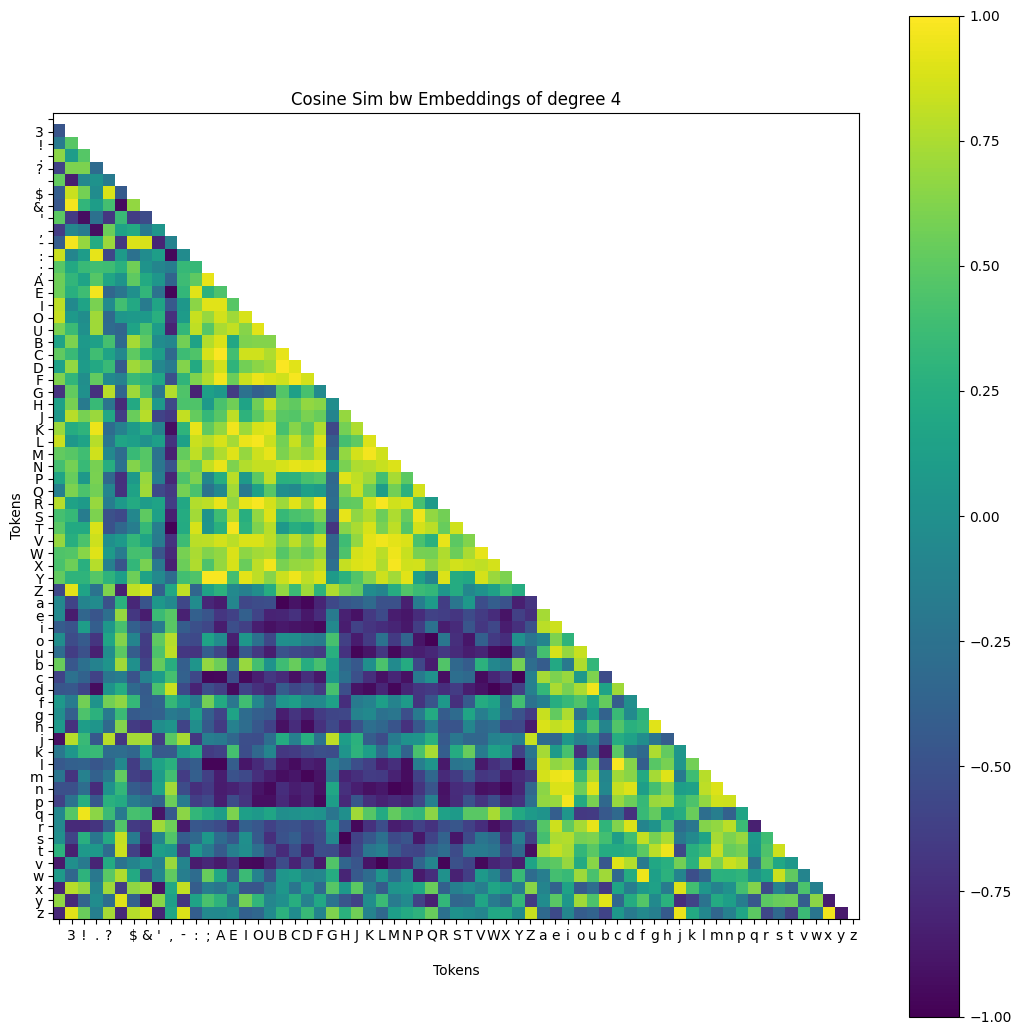

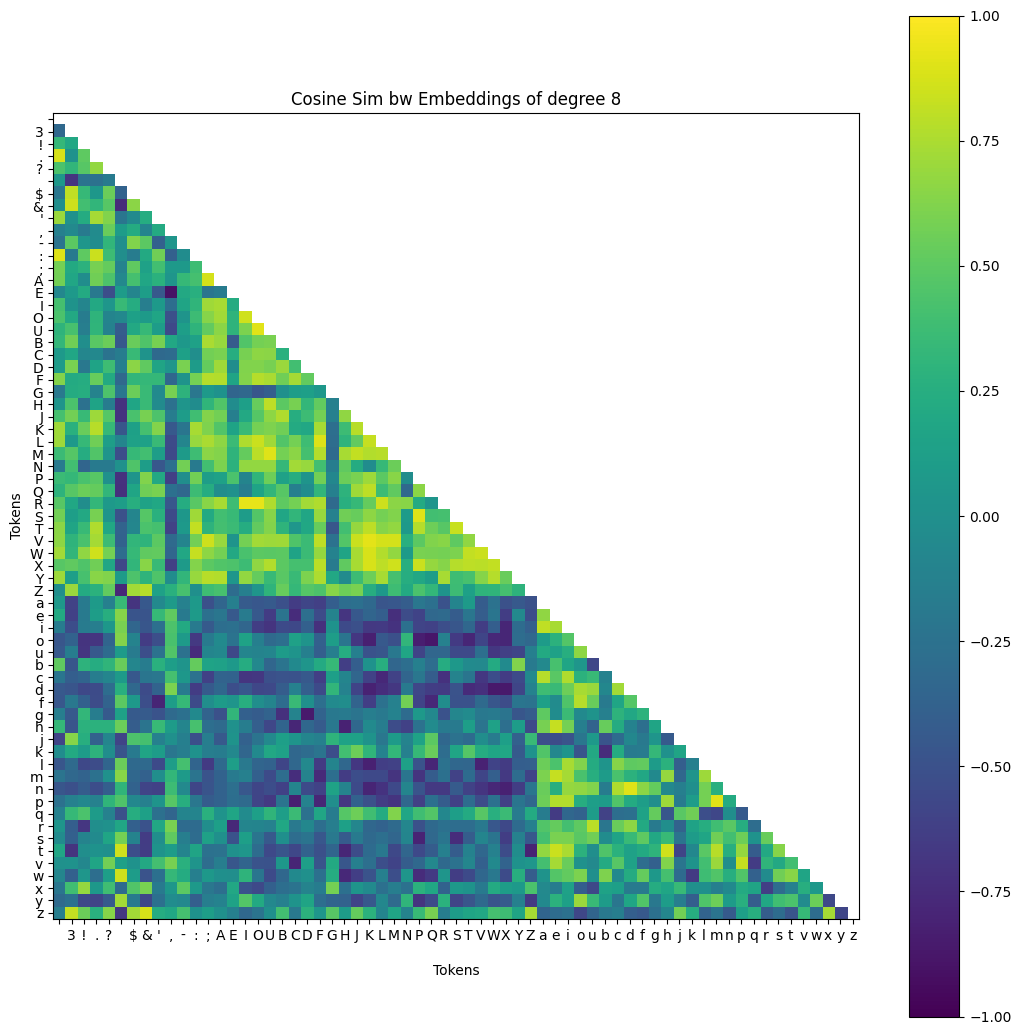

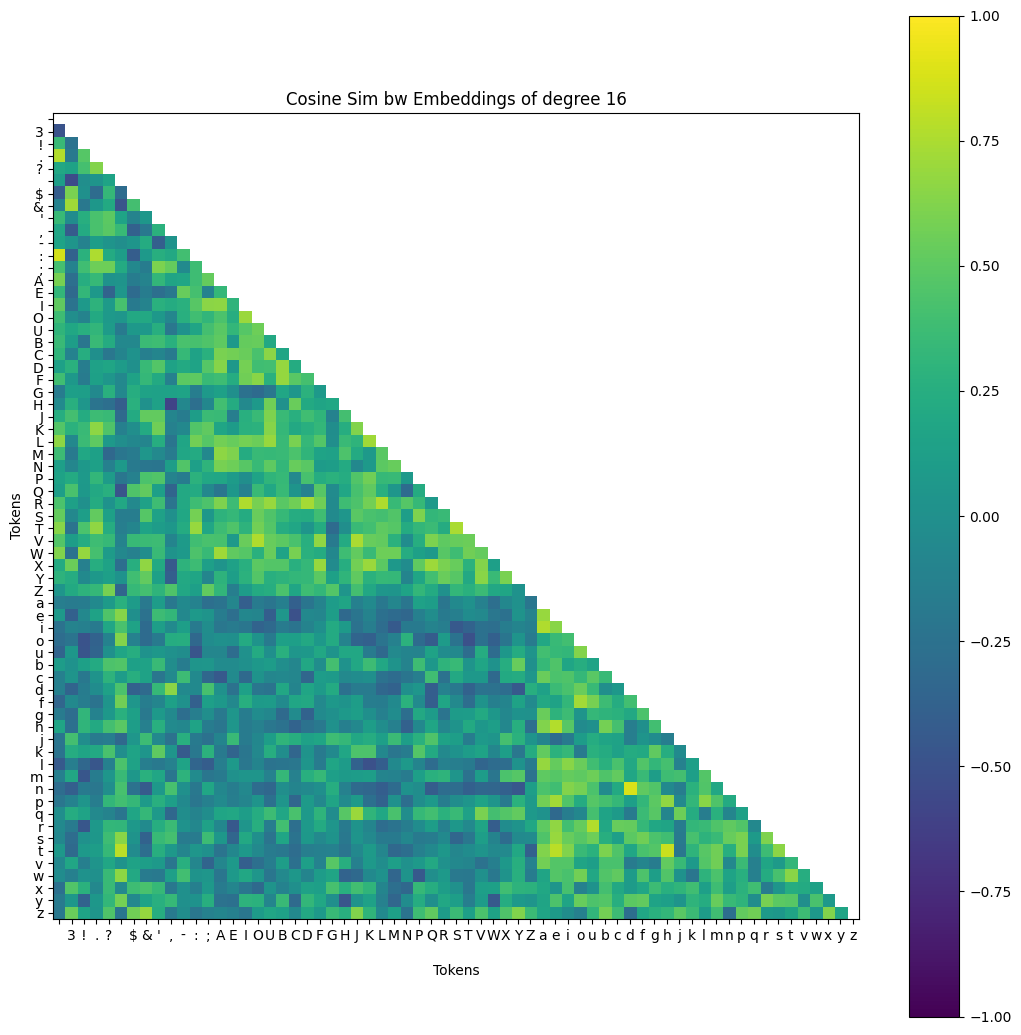

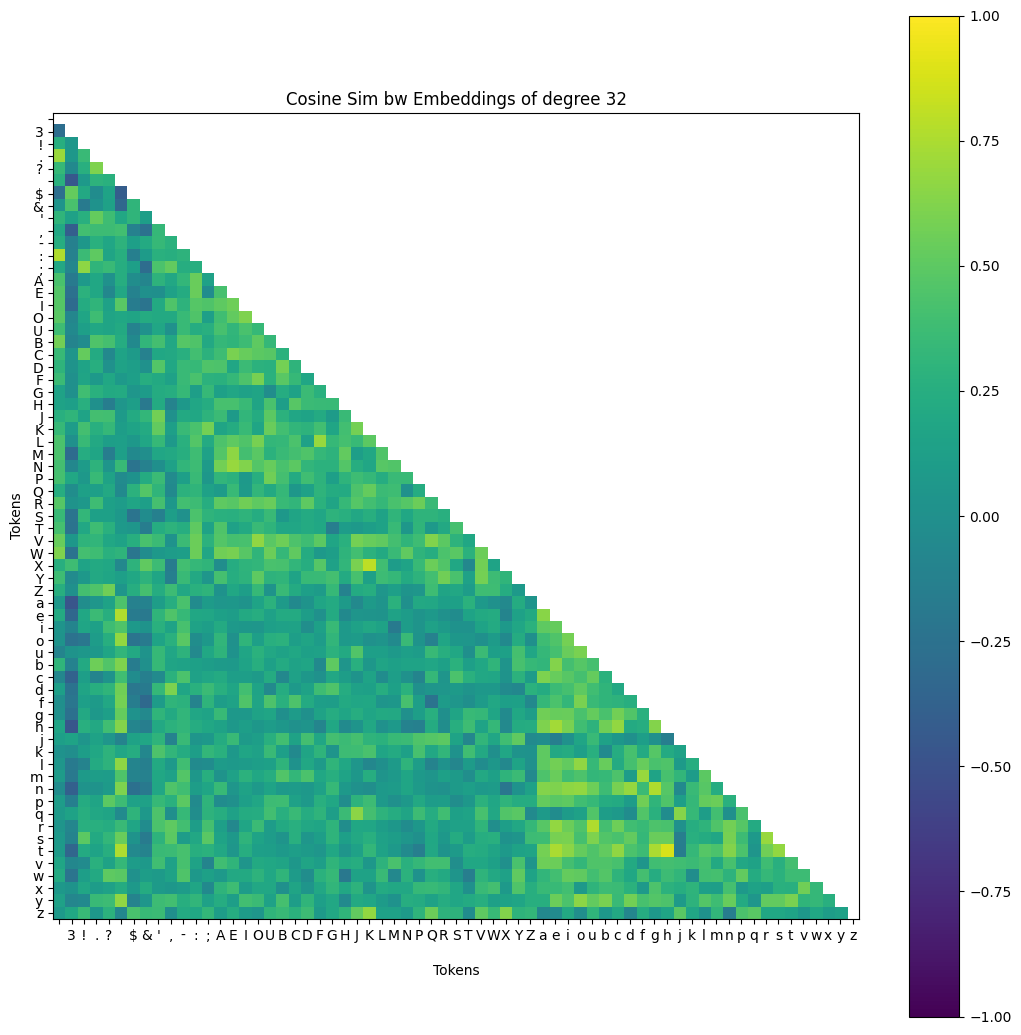

In [35]:
for i in range(min_power, power_of_d+1):
    save_path = f'images/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}_thispower{i}.png'
    plot_token_similarity(chars1, model, stoi, degree=i, size=13, save_path=None)